### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
import librosa
import keras
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.layers import LSTM, Dense, Dropout, Flatten

In [ ]:
X=np.load('/content/drive/MyDrive/ML_S/Tri train/X.npy')
Y=np.load('/content/drive/MyDrive/ML_S/Tri train/y.npy')

In [ ]:
## Splitting the data into 60% unlabeled 10% testing and 30% training
## stratify distributes the data into train and test according to class distribution in original dataset 
X_train, X_un, y_train, y_un = train_test_split(X, Y, test_size=0.6,random_state=1)
X_t, X_test, y_t, y_test = train_test_split(X_train, y_train, test_size=0.25,random_state=1)

In [ ]:
input_dim = (16, 8, 1)
dropout=0.1
n_classes=10
learning_rate = 0.0001

In [ ]:
X_t = X_t.reshape(len(X_t), 16, 8,1)
X_test = X_test.reshape(len(X_test), 16, 8,1)
X_un= X_un.reshape(len(X_un), 16, 8,1)

### CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "tanh"))
model.add(Dense(10, activation = "softmax"))

In [ ]:
opt = Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
callbacks = [ModelCheckpoint('/content/drive/MyDrive/CNN_base.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 40,restore_best_weights = True)]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 8, 64)         640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [ ]:
X__train, X__test, y__train, y__test = train_test_split(X_t, y_t, test_size=0.3)

In [ ]:
history = model.fit(X__train, y__train, epochs = 500, batch_size =200 , validation_data = (X__test, y__test), callbacks=callbacks)

Epoch 1/500
10/10 [==============================] - 2s 136ms/step - loss: 2.2385 - accuracy: 0.1755 - val_loss: 2.0781 - val_accuracy: 0.3168
Epoch 2/500
10/10 [==============================] - 1s 114ms/step - loss: 2.0297 - accuracy: 0.3313 - val_loss: 1.9462 - val_accuracy: 0.3346
Epoch 3/500
10/10 [==============================] - 1s 113ms/step - loss: 1.9163 - accuracy: 0.3809 - val_loss: 1.8555 - val_accuracy: 0.3906
Epoch 4/500
10/10 [==============================] - 1s 112ms/step - loss: 1.8222 - accuracy: 0.4202 - val_loss: 1.7930 - val_accuracy: 0.4211
Epoch 5/500
10/10 [==============================] - 1s 113ms/step - loss: 1.7601 - accuracy: 0.4327 - val_loss: 1.7577 - val_accuracy: 0.4288
Epoch 6/500
10/10 [==============================] - 1s 113ms/step - loss: 1.7017 - accuracy: 0.4506 - val_loss: 1.7153 - val_accuracy: 0.4644
Epoch 7/500
10/10 [==============================] - 1s 113ms/step - loss: 1.6470 - accuracy: 0.4601 - val_loss: 1.6930 - val_accuracy: 0.4809

### Evaluating baseline CNN

In [ ]:
model=keras.models.load_model("/content/drive/MyDrive/CNN_base.h5")
accuracy=model.evaluate(X_test,y_test)
accuracy=model.evaluate(X__train,y__train)

58/58 [==============================] - 0s 7ms/step - loss: 0.7002 - accuracy: 0.7687


### Correct predicted above threshold

In [ ]:
threshold =[0.9,0.99]

In [ ]:
  y_un_pred = model.predict(X_un)
  l = np.argmax(y_un_pred, axis=1)
  l_correct = []
  total=0
  correct=0
  for i in range(len(l)):
    if y_un_pred[i][l[i]]>=threshold[0]: 
        total=total+1
        if l[i]==np.argmax(y_un[i]):
          correct+=1
  print(correct*100/total)

93.8157894736842


In [ ]:
  y_un_pred = model.predict(X_un)
  l = np.argmax(y_un_pred, axis=1)
  l_correct = []
  total=0
  correct=0
  for i in range(len(l)):
    if y_un_pred[i][l[i]]>=threshold[1]: 
        total=total+1
        if l[i]==np.argmax(y_un[i]):
          correct+=1
  print(correct*100/total)

96.96969696969697


### Self Training CNN

In [ ]:
iteration=1
x_new=[0]*30
s=pd.DataFrame([])
iter=[]
labels_tobe_added=[]
val_acc=[]
labeled=[]
#rem_unlabeled=[]
unlabeled=[]
train_acc=[]

while len(x_new)>10 and len(X_un)>0 and iteration<6:

  X__train, X__val, y__train, y__val = train_test_split(X_t, y_t, test_size=0.3)
  labeled.append(len(X_t))
  unlabeled.append(len(X_un))
  print("labeled at start of iteration:",iteration," is ",len(X__train), "and unlabeled is",len(X_un))

  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = input_dim))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(1024, activation = "tanh"))
  model.add(Dense(10, activation = "softmax"))
  opt = Adam(lr=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  callbacks = [ModelCheckpoint('/content/drive/MyDrive/ML_S/CNN_self_train_0.9.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 25,restore_best_weights = True)]

  history = model.fit(X__train, y__train, epochs = 300, batch_size = 500, validation_data = (X__val, y__val), callbacks=callbacks)
  
  accuracy1=model.evaluate(X__val,y__val)
  print("val_accuracy=",accuracy1)
  iter.append(iteration)
  val_acc.append(accuracy1[1]*100)
  accuracy2=model.evaluate(X__train,y__train)
  train_acc.append(accuracy2[1]*100)
  print("train accuracy=",accuracy2)

  y_un_pred = model.predict(X_un)
  l = np.argmax(y_un_pred, axis=1)
  l_correct = []
  x_new = []
  y_new = []
  for i in range(len(y_un)):
    if y_un_pred[i][l[i]]>=0.9: 
      x_new.append(X_un[i])
      y_new.append(l[i])
      l_correct.append(i)
  y_new2 = to_categorical(y_new, num_classes=10)
  y_new=np.array(y_new2)
  x_new=np.array(x_new)
  if x_new.shape==(0,): break

  X_t = np.append(X_t, x_new, axis=0)
  y_t = np.append(y_t, y_new, axis=0)
  X_un = np.delete(X_un, l_correct, axis = 0)
  y_un = np.delete(y_un, l_correct, axis=0)
  print("unlabeled remaining=",len(X_un)," labels added=",len(x_new))
  labels_tobe_added.append(len(x_new))
  #rem_unlabeled.append(len(X_un))
  iteration=iteration+1

labeled at start of iteration: 1  is  1833 and unlabeled is 5240
Epoch 1/300
4/4 [==============================] - 2s 303ms/step - loss: 2.3182 - accuracy: 0.1165 - val_loss: 2.1753 - val_accuracy: 0.2557
Epoch 2/300
4/4 [==============================] - 1s 259ms/step - loss: 2.1601 - accuracy: 0.2563 - val_loss: 2.0752 - val_accuracy: 0.3130
Epoch 3/300
4/4 [==============================] - 1s 252ms/step - loss: 2.0682 - accuracy: 0.3102 - val_loss: 1.9938 - val_accuracy: 0.3321
Epoch 4/300
4/4 [==============================] - 1s 245ms/step - loss: 1.9863 - accuracy: 0.3359 - val_loss: 1.9306 - val_accuracy: 0.3677
Epoch 5/300
4/4 [==============================] - 1s 248ms/step - loss: 1.9282 - accuracy: 0.3622 - val_loss: 1.8837 - val_accuracy: 0.3880
Epoch 6/300
4/4 [==============================] - 1s 253ms/step - loss: 1.8798 - accuracy: 0.3872 - val_loss: 1.8410 - val_accuracy: 0.3995
Epoch 7/300
4/4 [==============================] - 1s 247ms/step - loss: 1.8268 - accurac

In [ ]:
s['Iteration']=iter
s['Training samples']=labeled
s['Unlabeled']=unlabeled
s['Train Accuracy']=train_acc
s['Validation Accuracy']=val_acc
s['labels>0.9']=labels_tobe_added

In [ ]:
s

,Iteration,Training samples,Unlabeled,Train Accuracy,Validation Accuracy,labels>0.9
0,1,2619,5240,83.196944,68.575066,2035
1,2,4654,3205,91.894382,82.390839,614
2,3,5268,2591,91.131002,83.934218,146
3,4,5414,2445,91.501713,83.630770,123
4,5,5537,2322,92.799997,84.175694,123


In [ ]:
s.to_csv('/content/drive/MyDrive/ML_S/self_CNN_0.9.csv')

In [ ]:
s

,Iteration,Training samples,Unlabeled,Train Accuracy,Validation Accuracy,labels>0.99
0,1,2619,5240,85.706490,66.412216,972
1,2,3591,4268,84.958220,75.046384,156
2,3,3747,4112,89.664376,78.933334,265
3,4,4012,3847,89.707977,80.149502,101
4,5,4113,3746,88.537687,80.145866,58
5,6,4171,3688,90.681738,81.230032,108
6,7,4279,3580,88.981634,79.750776,29
7,8,4308,3551,86.633497,79.273009,18
8,9,4326,3533,88.342142,80.893683,31


In [ ]:
s.to_csv('/content/drive/MyDrive/ML_S/self_CNN_0.9.csv')

### Evaluating the self trained CNN

In [ ]:
model=keras.models.load_model("/content/drive/MyDrive/ML_S/CNN_self_train.h5")
accuracy=model.evaluate(X_test,y_test)

28/28 [==============================] - 0s 8ms/step - loss: 1.0209 - accuracy: 0.7022


In [ ]:
y_pred = model.predict(X_test)
print(y_pred.shape)

(873, 10)


In [ ]:
print(np.argmax(y_test, axis=1))

In [ ]:
from sklearn.metrics import confusion_matrix

label=[ 'air_conditioner', 'car_horn', 'children_playing','dog_bark', 'drilling', 'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), labels)

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix of CNN', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('/content/drive/MyDrive/ML_A/CNN.png')
    plt.show()

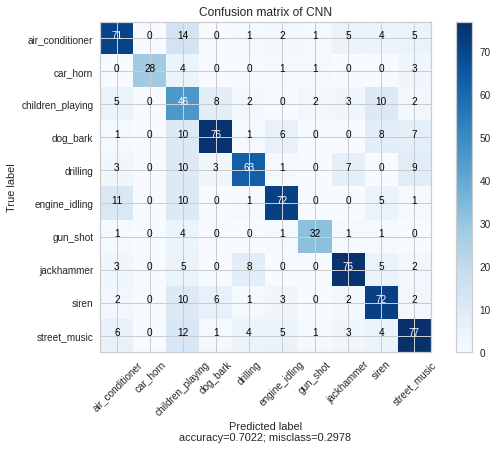

In [ ]:
plot_confusion_matrix(cm, label, normalize=False)

In [ ]:
from scipy import stats

In [ ]:
print(stat.mode(np.argmax(y_test, axis=1)))